Задание  
Берем отызывы за лето (из архива с материалами или предыдущего занятия)  
1. Учим conv сеть для классификации  
2. Рассмотреть 2-а варианта сеточек  
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/  
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)  
  
Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше  

In [4]:
max_words = 200
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 128
print_batch_n = 100

In [5]:
import pandas as pd

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [6]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [7]:
import re
def funk_del(input_txt):
    pattern = "@[\w]*"
    if re.findall(pattern, input_txt):
        return re.sub(pattern, ' ', input_txt)
    else:
        return re.sub(pattern, ' ', input_txt)


In [8]:
# df_train['text'] = df_train['text'].apply(funk_del)
# df_test['text'] = df_test['text'].apply(funk_del)
# df_val['text'] = df_val['text'].apply(funk_del)

In [9]:
# pattern = r'[^\w\s]'

# df_train['text'] = df_train['text'].apply(lambda x: re.sub(pattern, ' ', x))
# df_test['text'] = df_test['text'].apply(lambda x: re.sub(pattern, ' ', x))
# df_val['text'] = df_val['text'].apply(lambda x: re.sub(pattern, ' ', x))



In [10]:
# pattern = r'[^а-яА-Я0-9]'
# df_train['text'] = df_train['text'].apply(lambda x: re.sub(pattern, ' ', x))
# df_test['text'] = df_test['text'].apply(lambda x: re.sub(pattern, ' ', x))
# df_val['text'] = df_val['text'].apply(lambda x: re.sub(pattern, ' ', x))



In [11]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [12]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

In [13]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt =  re.sub(r'[^а-яА-Я]', ' ', txt) # Заменим спец. символы на пробелы
    txt = funk_del(txt) # Удалим @word из всех твитов
#     txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [14]:
df_train.head()

,id,text,class
0,0,уезжаааааааать тожена хотеть уезжать,0
1,1,ребята девчата кино любовь завтра вотэтолюбовь,1
2,2,ктоненавидеть пробка ретвит,0
3,3,хотеться котлета киевск запретный плод,1
4,4,босапоп есбосан бояться мороз,1


In [15]:
train_corpus = " ".join(df_train["text"])


In [16]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VoronkovSergey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
tokens = word_tokenize(train_corpus)

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [18]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [19]:
len(set(tokens_filtered))

96559

<BarContainer object of 220 artists>

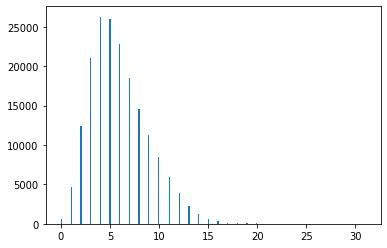

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(df_train.text.apply(lambda text: len(text.split())), bins='auto')
hist

In [21]:
num_tok = 0
for i, row in df_train.iterrows():
    line = len(row['text'].split())
    if num_tok < line:
        num_tok = line

num_tok       

31

In [22]:
max_words = 12000
max_len = 31

In [23]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

до удаления числовых символов

In [71]:
tokens_filtered_top[:10]

['хотеть', '3', '1', '2', '4', 'знать', '5', '9', 'любить', 'ян']

после удаления, слова больше смысла имеют

In [24]:
tokens_filtered_top[:20]

['хотеть',
 'знать',
 'любить',
 'ян',
 'мочь',
 'завтра',
 'новый',
 'вс',
 'мой',
 'хороший',
 'делать',
 'смотреть',
 'блин',
 'думать',
 'вообще',
 'день',
 'спать',
 'идти',
 'дом',
 'самый']

In [25]:
vocabulary = {v: k for k, v in enumerate(tokens_filtered_top, 1)}

In [26]:
vocabulary

{'хотеть': 1,
 'знать': 2,
 'любить': 3,
 'ян': 4,
 'мочь': 5,
 'завтра': 6,
 'новый': 7,
 'вс': 8,
 'мой': 9,
 'хороший': 10,
 'делать': 11,
 'смотреть': 12,
 'блин': 13,
 'думать': 14,
 'вообще': 15,
 'день': 16,
 'спать': 17,
 'идти': 18,
 'дом': 19,
 'самый': 20,
 'иня': 21,
 'друг': 22,
 'сидеть': 23,
 'утро': 24,
 'писать': 25,
 'сделать': 26,
 'один': 27,
 'пойти': 28,
 'школа': 29,
 'человек': 30,
 'какой': 31,
 'настроение': 32,
 'ещ': 33,
 'ждать': 34,
 'мама': 35,
 'час': 36,
 'болеть': 37,
 'такой': 38,
 'любимый': 39,
 'говорить': 40,
 'написать': 41,
 'хотеться': 42,
 'видеть': 43,
 'работа': 44,
 'посмотреть': 45,
 'ночь': 46,
 'х': 47,
 'добрый': 48,
 'последний': 49,
 'понять': 50,
 'прийти': 51,
 'купить': 52,
 'понимать': 53,
 'нравиться': 54,
 'скучать': 55,
 'свой': 56,
 'скоро': 57,
 'найти': 58,
 'дело': 59,
 'давать': 60,
 'вчера': 61,
 'читать': 62,
 'урок': 63,
 'забыть': 64,
 'плохо': 65,
 'остаться': 66,
 'стать': 67,
 'работать': 68,
 'фильм': 69,
 'первый'

In [27]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = (maxlen-len(result)) * [0]
    return  result[-maxlen:] + padding

In [28]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [29]:
x_train.shape

(181467, 31)

In [30]:
x_train[1]

array([ 191, 6285,  432,  149,    6,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

# Keras model

In [31]:
import numpy as np
# import keras
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPool1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras import losses
# from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [32]:
# keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)

In [33]:
num_classes = 2
y_train = keras.utils.to_categorical(df_train["class"], num_classes)
y_val = keras.utils.to_categorical(df_val["class"], num_classes)

In [34]:
# ?GlobalMaxPool1D

In [35]:
import keras
print('keras: %s' % keras.__version__)

keras: 2.9.0


In [36]:
num_classes = 2

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [55]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 31, 128)           1536000   
                                                                 
 conv1d_20 (Conv1D)          (None, 29, 128)           49280     
                                                                 
 activation_36 (Activation)  (None, 29, 128)           0         
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 10)                1290      
                                                                 
 activation_37 (Activation)  (None, 10)                0         
                                                     

In [43]:

model1 = Sequential()
model1.add(Embedding(input_dim=max_words, output_dim=512, input_length=max_len))
model1.add(Conv1D(512, 3, padding = 'same'))
model1.add(Activation("tanh"))
model1.add(MaxPool1D(pool_size=3, strides=3))
# model.add(GlobalMaxPool1D())
model1.add(Conv1D(256, 3, padding = 'same'))
model1.add(Activation("tanh"))
model1.add(MaxPool1D(pool_size=3, strides=3))
# model.add(GlobalMaxPool1D())
model1.add(Conv1D(128, 2, padding = 'same'))
model1.add(Activation("tanh"))
# model1.add(MaxPool1D(pool_size=2, strides=1))
model1.add(GlobalMaxPool1D())
model1.add(Dense(10))
model1.add(Activation("relu"))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 512)           6144000   
                                                                 
 conv1d_14 (Conv1D)          (None, 31, 512)           786944    
                                                                 
 activation_22 (Activation)  (None, 31, 512)           0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 10, 512)          0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 10, 256)           393472    
                                                                 
 activation_23 (Activation)  (None, 10, 256)           0         
                                                      

In [56]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
319/319 [==============================] - 294s 920ms/step - loss: 0.5904 - accuracy: 0.6715 - val_loss: 0.5461 - val_accuracy: 0.7183
Epoch 2/20
319/319 [==============================] - 338s 1s/step - loss: 0.5020 - accuracy: 0.7537 - val_loss: 0.5453 - val_accuracy: 0.7231


In [58]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
319/319 [==============================] - 17s 54ms/step - loss: 0.4160 - accuracy: 0.8076 - val_loss: 0.5766 - val_accuracy: 0.7210
Epoch 2/20
319/319 [==============================] - 16s 49ms/step - loss: 0.3114 - accuracy: 0.8650 - val_loss: 0.6731 - val_accuracy: 0.7127


модель где три conv1d слоя обучалась гораздо дольше, но результат на валидации немного лучше, а accuracy больше на меньше  количестве слоев, думаю вторая легче переобучается, за такой надо внимательнее следить

In [37]:
token_dict = {}

читаю веса токенов из скачаной модели

In [38]:
p = r'[a-zA-Zа-яА-Я]'
with open('model.txt','r',buffering=100000, encoding='utf-8') as f:
    for line in f:
        line = line.split('_')
        if len(line)==1:
            pass
        else:
            k = line[0]
            v = re.sub(p, '', line[1]).split()
#             print(v)
            v = [re.sub('-', '', i) for i in v]
#             print(v)
            v = [float(i) for i in v]
            token_dict[k] = v
#             token_dict[line.split('_')[0]] = re.sub(p, '', line.split('_')[1]).split()
#             token_dict = {i:j for i,j in line.split('_')}
#         print (line, '\n', '-'*30, '\n')

In [39]:
len(token_dict)

205707

In [52]:
a = [1,2,3,4,5]
np.mean(a)

3.0

беру среднее каждого вектора токена, взять все 300 для обучения у меня не получилось, пк не справился

In [58]:
import numpy as np
maxlen = 31
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in token_dict:
#             [result.append(i) for i in token_dict[word]]
            result.append(np.mean(token_dict[word]))
    padding = (maxlen-len(result)) * [0]
    return  result[-maxlen:] + padding

In [56]:
from tqdm import tqdm_notebook

In [59]:
x_train = np.asarray([text_to_sequence(text, maxlen) for text in tqdm_notebook(df_train["text"])], dtype=np.float32)
x_test = np.asarray([text_to_sequence(text, maxlen) for text in tqdm_notebook(df_test["text"])], dtype=np.float32)
x_val = np.asarray([text_to_sequence(text, maxlen) for text in tqdm_notebook(df_val["text"])], dtype=np.float32)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/181467 [00:00<?, ?it/s]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/22684 [00:00<?, ?it/s]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/22683 [00:00<?, ?it/s]

In [44]:
31*300

9300

In [60]:
x_train.shape

(181467, 31)

In [61]:
len(x_train[1])

31

In [62]:
model3 = Sequential()
model3.add(Embedding(input_dim=x_train.shape[0], output_dim=batch_size, input_length=x_train.shape[1]))
model3.add(Conv1D(128, 3))
model3.add(Activation("relu"))
model3.add(GlobalMaxPool1D())
model3.add(Dense(10))
model3.add(Activation("relu"))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 512)           92911104  
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 128)           196736    
                                                                 
 activation_3 (Activation)   (None, 29, 128)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 activation_4 (Activation)   (None, 10)                0         
                                                      

In [63]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [64]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model3.fit(x_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/10
319/319 [==============================] - 308s 960ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6931 - val_accuracy: 0.5049
Epoch 2/10
319/319 [==============================] - 296s 926ms/step - loss: 0.6930 - accuracy: 0.5076 - val_loss: 0.6931 - val_accuracy: 0.5049


точность стоит на месте, может стоит попробывать добавить слои конвулиционные, но у меня уже компьютер на пределе работает, из трех моделей лучше всего я считаю показала себя с тремя conv1d слоями обученная на самостоятельно построенных эмбедингах, ее стоит обучить побольше